__собираем статистики по объявлениям о продаже домов__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
!date

Чт 13 июн 2024 12:41:06 MSK


# загружаем данные

In [2]:
import pandas as pd
import geopandas as gpd

pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
df = pd.read_pickle('data/2024/df_house.pkl')
df['dt'] = df['ts'].dt.date
display( len(df) )
cols = ['title','address','latitude','longitude','priceM','dt']
display( df.sample(3)[cols] )

13909

,title,address,latitude,longitude,priceM,dt
9206,"дом 360 м² на участке 6,3 сот.","севастополь,снт эллада,3",44.563999,33.435546,25.30,2024-06-10
11757,"дом 276,3 м² на участке 2 сот.","судак,ул.14 апреля,17",44.850896,34.974756,25.00,2024-06-07
7217,"дом 103 м² на участке 5,1 сот.","севастополь,садоводческое товарищество электрон-2,53",44.558739,33.44205,9.70,2024-06-13


---

In [4]:
df_ = pd.read_pickle('data/2023/data_house.pkl').rename(columns={'adr':'address'})
df_['dt'] = df_['ts'].dt.date
display( len(df_) )
display( df_.sample(3)[cols] )

24429

,title,address,latitude,longitude,priceM,dt
14541,дом 130 м² на участке 4 сот.,"Севастополь,Маслиновая ул., 36",44.646104,33.544539,7.00,2022-11-15
20662,дом 60 м² на участке 5 сот.,"Севастополь,садоводческое товарищество Дергачи-1",44.573721,33.586724,6.69,2024-06-04
22558,дом 100 м² на участке 4 сот.,"Севастополь,садоводческое товарищество Гераклея",44.539448,33.480471,5.29,2024-06-05


In [5]:
df_ = (
        df_
        .dropna(subset=['dt','url'])
        .drop_duplicates(['dt','url'])
        .drop(columns=['adr_orig','obj_name','avito_page'])
    )
display( len(df_) )
cols = ['title','address','latitude','longitude','priceM','dt','url']
display( df_.sample(3)[cols] )

24176

,title,address,latitude,longitude,priceM,dt,url
10329,"дом 140 м² на участке 4,4 сот.","Севастополь,садоводческое товарищество Скиф",44.548423,33.481208,3.90,2022-11-04,https://avito.ru/2448656612
4852,"дом 95 м² на участке 5,8 сот.","Севастополь,товарищество собственников недвижимости Водоканал-1, 4",44.582119,33.546973,9.88,2022-09-16,https://avito.ru/2359377619
23083,дом 280 м² на участке 10 сот.,"Севастополь,ш. Генерала Моргунова, 135",44.557204,33.559873,17.80,2024-06-05,https://avito.ru/2672244826


In [6]:
# df_['dt'].drop_duplicates()


In [7]:
# history_date = df_['dt'].max()
history_date = pd.to_datetime('2023-01-10').date()
display(history_date)

datetime.date(2023, 1, 10)

In [8]:
df = pd.concat([df,df_]).reset_index(drop=True)
display( len(df) )
del df_

38085

In [9]:
df['month'] = df['ts'].dt.to_period('M')

---

In [10]:
# df['dt'].drop_duplicates().sort_values()

In [11]:
# display( len(df) )
# df = df[ df['dt']!=pd.to_datetime('2024-06-04').date() ]
# display( len(df) )
# df = df[ df['dt']!=pd.to_datetime('2024-06-05').date() ]
# display( len(df) )
# df = df.reset_index(drop=True)

---

In [12]:
df['latitude'] = pd.to_numeric( df['latitude'], errors='coerce' )
df['longitude'] = pd.to_numeric( df['longitude'], errors='coerce' )

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38085 entries, 0 to 38084
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   url                  38085 non-null  object        
 1   place                38085 non-null  object        
 2   title                38085 non-null  object        
 3   subtitle             6251 non-null   object        
 4   price                38085 non-null  int64         
 5   address              38085 non-null  object        
 6   description          38085 non-null  object        
 7   ts                   38085 non-null  datetime64[ns]
 8   house_area           38085 non-null  float64       
 9   is_part              38085 non-null  bool          
 10  is_townhouse         38085 non-null  bool          
 11  is_SNT               38085 non-null  bool          
 12  land_area            38085 non-null  float64       
 13  priceM               38085 non-

In [14]:
df.loc[ df['address']=='квартал Старый Город', ['latitude','longitude']] = None
df.loc[ df['url']=='https://avito.ru/2322251740', ['latitude','longitude']] = None

df.loc[ df['address']=='Севастополь,Чёрное море', ['latitude','longitude'] ] = None
df.loc[ df['address'].str.lower().str.match('чёрное море'), ['latitude','longitude'] ] = None 
df.loc[ df['address'].str.lower().str.match('анталья'), ['latitude','longitude'] ] = None 

df.loc[ df['longitude']<30., ['latitude','longitude'] ] = None 

In [15]:
df.loc[ df['address'].str.lower().str.match(r'.*ялта.*') , 'place' ] = 'yalta'
df.loc[ df['address'].str.lower().str.match(r'.*алушта.*') , 'place' ] = 'alushta'
df.loc[ df['address'].str.lower().str.match(r'.*феодосия.*') , 'place' ] = 'feodosia'

df.loc[ df['address'].str.lower().str.match(r'.*окуневка.*') , 'place' ] = 'tarkhankut'
df.loc[ df['address'].str.lower().str.match(r'.*заветное.*') , 'place' ] = 'kerch'

In [16]:
display( len(df) )
df = df.dropna(subset=['latitude','longitude'])
display( len(df) )

38085

38043

In [17]:
display(len(df))
# выкидываем "ущербные" варианты 
df = df.query('~(is_part) & (house_area>40.) & (priceM<15.)')
display(len(df))
df = df.query('priceM>1.') # выкидываем предожения с аномально низкой ценой
display(len(df))

38043

27058

27012

In [18]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
# [['title','address','latitude','longitude','priceM']] 
display( gdf.sample(3)[cols])

,title,address,latitude,longitude,priceM,dt,url
6775,"дом 111,4 м² на участке 4,7 сот.","севастополь,ул.артиллеристов,41",44.59,33.54,11.30,2024-06-13,https://www.avito.ru/3505237140
4002,"дом, 90 м², 4 сот., ижс","севастополь,р-н нахимовский,с.вишневое,улица новая,20",44.73,33.61,7.80,2024-06-10,https://sevastopol.cian.ru/sale/suburban/295760466/
19313,дом 50 м² на участке 3 сот.,"Бахчисарай,Севастопольская ул., 93",44.75,33.87,4.00,2022-09-16,https://avito.ru/1989031755


---

In [19]:
dt_max = df['dt'].max()
dt_min = df['dt'].min()
display( dt_min,history_date,dt_max )

datetime.date(2022, 9, 15)

datetime.date(2023, 1, 10)

datetime.date(2024, 6, 13)

In [20]:
gdf = gdf.query('place in ("bahchisaray","sudak","sevastopol")')

In [21]:
# gdf_history = gdf.query(f'dt <= @history_date')
# gdf = gdf.query(f'dt > @history_date')

In [22]:
# display( len(gdf_history) )
# display( len(gdf) )

---

In [23]:
# cols = ['title','address','latitude','longitude','priceM','dt','place','url']
# gdf[ (gdf['place']=='sevastopol') & (gdf['address'].str.match(r'.*Судак.*')) ][cols]

In [24]:
# gdf['place'].unique()

# общая статистика

In [25]:
gdf[['title','address','priceM','geometry']].sample(512).explore()

In [26]:
gdf.query('place=="sevastopol"')[['title','address','priceM','geometry']].sample(512).explore()

In [27]:
# gdf[ gdf['address'].str.match(r'.*ялта.*') ]
# gdf[ gdf['address'].str.match(r'.*окуневка.*') ]
# gdf[ gdf['address'].str.match(r'.*заветное.*') ]

In [28]:
gdf.query('place=="sudak"')[['title','address','priceM','geometry']].explore()

In [29]:
# cols = ['title','adr','priceM','house_size_category','place','url','geometry']

In [30]:
# percentiles=[.01,.05,.1,.25,.5,.75,.9]
# stat = gdf.groupby(['place','house_size_category','dt'],observed=True)['priceM'].describe(percentiles=percentiles)
# stat_history = gdf_history.groupby(['place','house_size_category','dt'],observed=True)['priceM'].describe(percentiles=percentiles)

# display( stat )
# display( stat_history )

In [31]:
percentiles=[.01,.05,.1,.25,.5,.75,.9,.95]
stat = (
        gdf.groupby(['place','house_size_category','month'],observed=True)
        ['priceM'].describe(percentiles=percentiles)
    )
# stat_history = (
#         gdf_history.groupby(['place','house_size_category','month'],observed=True)
#         ['priceM'].describe(percentiles=percentiles)
#     )

display( stat )
# display( stat_history )

count  mean  std  min   1%   5%  10%  \
place       house_size_category month                                           
bahchisaray 30-50               2022-09  71.00  3.44 1.39 1.60 1.60 1.75 2.00   
                                2022-10  33.00  3.21 1.24 1.50 1.56 1.70 1.80   
                                2022-11  93.00  3.26 1.31 1.39 1.39 1.68 1.80   
                                2023-01  20.00  3.52 1.43 1.80 1.80 1.80 1.98   
                                2024-06 173.00  3.88 1.53 2.00 2.00 2.12 2.22   
...                                        ...   ...  ...  ...  ...  ...  ...   
sudak       300+                2022-09  15.00  9.33 0.49 9.00 9.00 9.00 9.00   
                                2022-10   6.00  9.33 0.52 9.00 9.00 9.00 9.00   
                                2022-11   7.00  9.54 1.44 9.00 9.00 9.00 9.00   
                                2023-01   3.00 10.27 2.19 9.00 9.00 9.00 9.00   
                                2024-06  36.00 11.08 1.69 9.00 9.00 9.00 9.00   

                                         25%   50%   75%   90%   95%   max  
place       house_size_category month                                       
bahchisaray 30-50               2022-09 2.50  3.30  4.00  4.70  6.25  7.90  
                                2022-10 2.48  2.85  3.90  4.66  5.02  7.00  
                                2022-11 2.48  2.85  3.90  5.50  5.88  7.00  
                                2023-01 2.20  3.45  4.55  5.55  6.02  6.35  
                                2024-06 2.40  3.80  4.95  5.86  6.35  9.00  
...                                      ...   ...   ...   ...   ...   ...  
sudak       300+                2022-09 9.00  9.00 10.00 10.00 10.00 10.00  
                                2022-10 9.00  9.00  9.75 10.00 10.00 10.00  
                                2022-11 9.00  9.00  9.00 10.52 11.66 12.80  
                                2023-01 9.00  9.00 10.90 12.04 12.42 12.80  
                                2024-06 9.00 11.25 12.50 13.50 13.50 13.50  

[70 rows x 13 columns]

In [32]:
# percentiles=[.01,.05,.1,.25,.5,.75,.9]
# stat = gdf.groupby(['place','house_size_category','dt'],observed=True)['priceM'].describe(percentiles=percentiles)
# display( stat )

In [33]:
import matplotlib.pyplot as plt

cols = ['1%','10%','25%','50%']
sizes = stat.reset_index()['house_size_category'].unique()
sizes = ['50-70', '70-150', '150-300' ]
display(sizes)

['50-70', '70-150', '150-300']

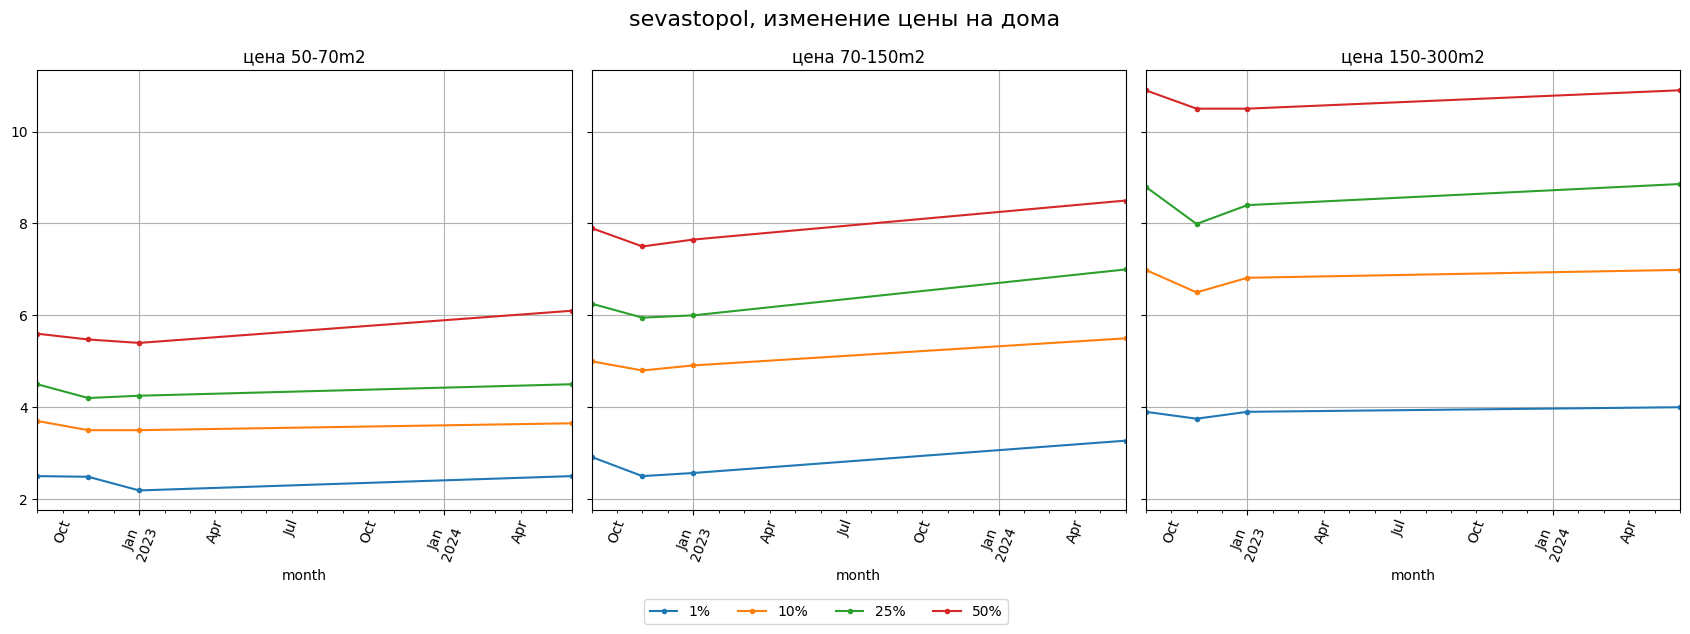

In [34]:
place = 'sevastopol'

fig, ax = plt.subplots(1,len(sizes),figsize=(17,6), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена {s}m2', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на дома', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

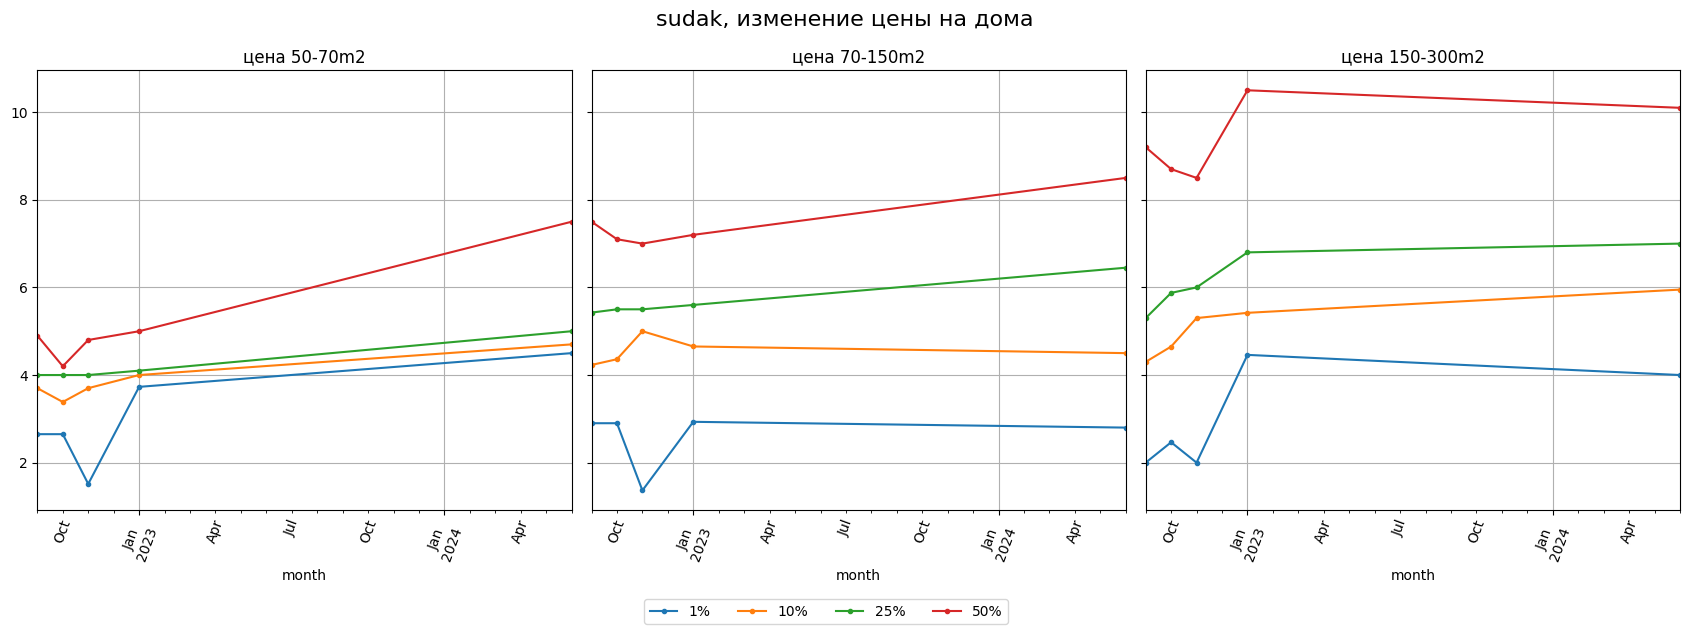

In [35]:
place = 'sudak'

fig, ax = plt.subplots(1,len(sizes),figsize=(17,6), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена {s}m2', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на дома', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

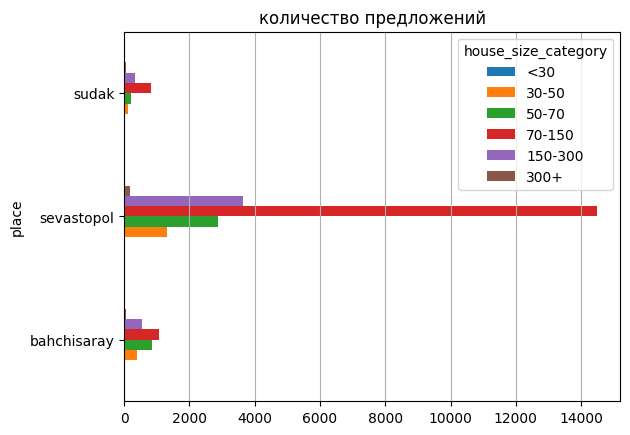

In [36]:
(
gdf
.groupby(['house_size_category','place'],observed=False)['url'].count().reset_index()
# .query('place in ("bahchisaray","sudak","sevastopol")')
.pivot(index='place', columns='house_size_category', values='url')
.plot.barh(title='количество предложений') #,log=True)
.grid(axis='x')    
)

# актуальная цена

In [37]:
display(len(gdf))
gdf_last = gdf[ gdf['dt'] == gdf['dt'].max() ]
display(len(gdf_last))

26976

2546

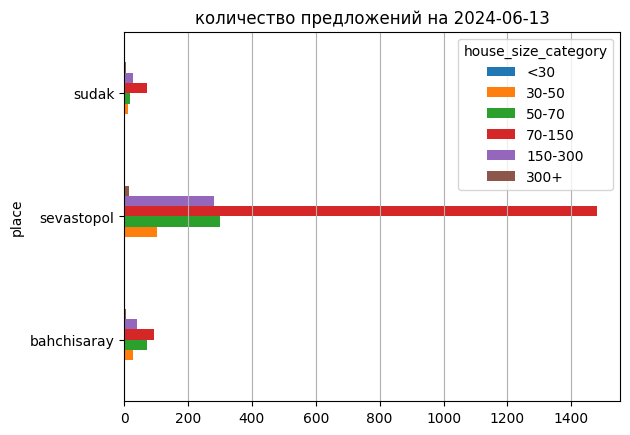

In [38]:
(
gdf_last
.groupby(['house_size_category','place'],observed=False)['url'].count().reset_index()
.pivot(index='place', columns='house_size_category', values='url')
.plot.barh(title='количество предложений на '+ str( gdf['dt'].max() ))
.grid(axis='x')    
)

In [39]:
(
    gdf_last
    .groupby(['place','house_size_category'],observed=False)
    ['priceM'].describe(percentiles=percentiles)
)

count  mean  std   min    1%    5%   10%  \
place       house_size_category                                              
bahchisaray 30-50                 28.00  3.90 1.64  2.00  2.00  2.07  2.22   
            50-70                 71.00  5.77 2.12  1.80  1.80  2.65  3.20   
            70-150                92.00  6.84 3.01  1.50  1.64  2.56  3.31   
            150-300               39.00  9.14 3.17  2.30  2.95  4.00  4.94   
            300+                   5.00 12.40 1.52 10.00 10.08 10.40 10.80   
sevastopol  30-50                102.00  5.39 2.02  1.95  2.50  2.90  3.40   
            50-70                299.00  6.42 2.13  1.37  2.50  3.50  3.74   
            70-150              1479.00  8.70 2.43  1.43  3.47  4.67  5.50   
            150-300              280.00 10.54 2.59  3.50  3.97  6.20  6.89   
            300+                  16.00  9.67 3.29  3.80  3.90  4.33  5.00   
sudak       30-50                 11.00  9.64 3.76  3.99  4.04  4.25  4.50   
            50-70                 18.00  7.65 2.35  4.50  4.53  4.67  4.70   
            70-150                72.00  8.67 2.81  2.80  3.08  4.48  4.78   
            150-300               28.00 10.48 3.58  4.00  4.05  4.30  5.52   
            300+                   6.00 11.08 1.83  9.00  9.00  9.00  9.00   

                                  25%   50%   75%   90%   95%   max  
place       house_size_category                                      
bahchisaray 30-50                2.40  3.90  4.72  5.64  6.21  9.00  
            50-70                4.60  5.50  7.20  8.90  9.97 10.00  
            70-150               4.95  6.50  8.60 11.55 12.50 14.00  
            150-300              6.50  9.95 11.15 13.50 14.03 14.55  
            300+                12.00 13.00 13.00 13.60 13.80 14.00  
sevastopol  30-50                3.80  5.00  6.50  7.77  9.49 12.00  
            50-70                4.80  6.40  7.70  9.21 10.00 14.00  
            70-150               7.00  8.60 10.50 11.95 12.62 14.90  
            150-300              8.84 10.74 12.31 14.00 14.50 15.00  
            300+                 8.50  9.20 12.25 13.50 14.20 14.80  
sudak       30-50                7.25  9.20 13.20 13.50 13.75 14.00  
            50-70                5.50  7.65  8.30 11.01 11.65 12.50  
            70-150               6.50  8.50 11.05 12.40 12.81 13.50  
            150-300              7.75 11.15 13.57 14.92 14.95 14.99  
            300+                 9.50 11.25 12.25 13.00 13.25 13.50

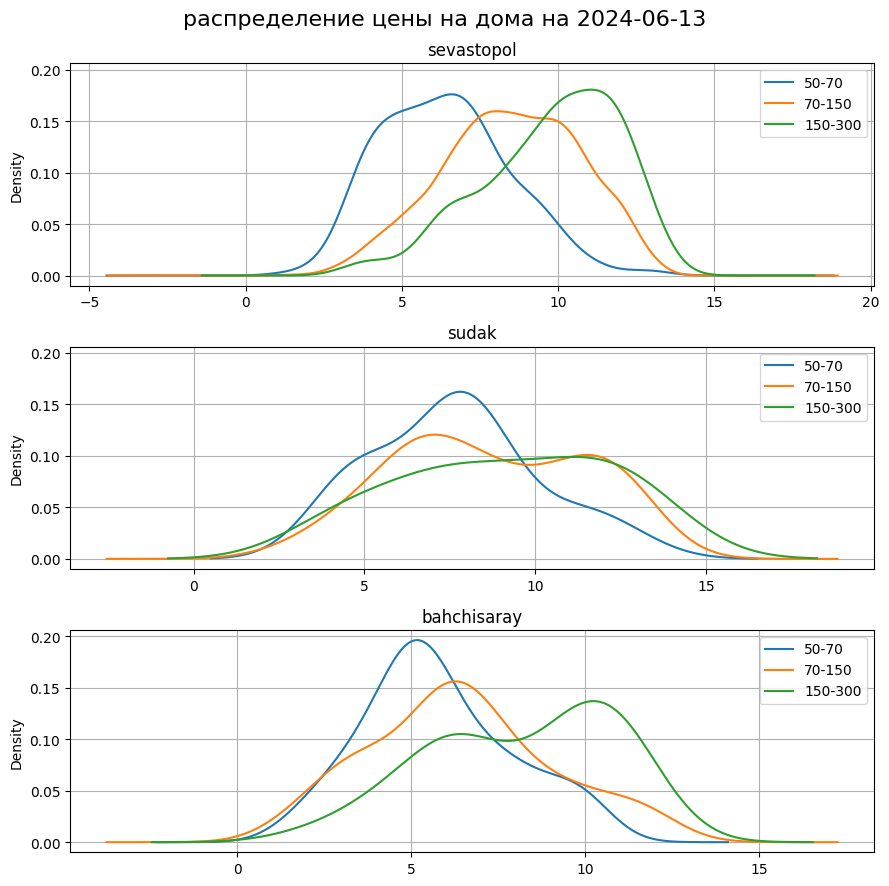

In [40]:
q_95 = gdf_last.groupby(['place'])['priceM'].quantile(.95)

places = ['sevastopol','sudak','bahchisaray']
category = ['50-70', '70-150', '150-300' ]
# category = ['50-70', '70-150', '150-300', '30-50', '300+']

fig, ax = plt.subplots(len(places),1,figsize=(9,9), sharey=True )
for i,p in enumerate(places): 
    (
        gdf_last
        .query(f'(place=="{p}")&(priceM<{q_95[p]})&(house_size_category in {category})')
        .groupby(['house_size_category'],observed=True)
        ['priceM']
        .plot.kde(legend=True,ax=ax[i],title=f'{p}', grid=True)   
    )
fig.suptitle(f'распределение цены на дома на '+ str( gdf_last['dt'].max() ), fontsize=16)
fig.tight_layout()

# цены на карте

In [41]:
import h3
from shapely.geometry import Polygon
from shapely.geometry import MultiPoint

In [42]:
def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame({ 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },crs=crs,)

In [43]:
# cols = ['title','address','latitude','longitude','priceM','dt','url']
# gdf_last.query('place=="sevastopol"')[cols]

In [44]:
# gdf_last[gdf_last['place']=='sevastopol'][cols]

## Севастополь

In [45]:
frame_sevastopol = gpd.GeoDataFrame([{ # все предложения
            'place':'sevastopol', 
            'geometry':MultiPoint( gdf_last.query('place=="sevastopol"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

frame_sevastopol.explore()

In [46]:
grid = cover_grid_hexagonal( frame_sevastopol.geometry.values[0],cell_size=7 )
grid_values = ( 
    grid
    .sjoin( gdf_last.query('place=="sevastopol"'), how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)
grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

## Судак

In [47]:
frame_sudak = gpd.GeoDataFrame([{ # все предложения
            'place':'sudak', 
            'geometry':MultiPoint( gdf_last.query('place=="sudak"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

# frame_sudak.explore()

In [48]:
grid = cover_grid_hexagonal( frame_sudak.geometry.values[0],cell_size=8 )
grid_values = ( 
    grid
    .sjoin( gdf_last.query('place=="sudak"'), how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)
grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

# районы Севастополя

In [49]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
        { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
        for nm,f in frames_index.values
    ],crs='epsg:4326',)

In [50]:
display(frames)

,area_name,geometry
0,"Севастополь, район Острякова","POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))"
1,"Севастополь, парк 60-летия СССР","POLYGON ((33.51805 44.58404, 33.51458 44.58408, 33.51263 44.58031, 33.51435 44.57460, 33.52004 44.57520, 33.51805 44.58404))"
2,"Севастополь, Хрусталёва/Хрюкина","POLYGON ((33.52003 44.57511, 33.52527 44.56364, 33.52116 44.56136, 33.51942 44.56406, 33.51951 44.56384, 33.51874 44.56882, 33.51426 44.57444, 33.52003 44.57511))"
3,"Севастополь, Геловани/Коломийца","POLYGON ((33.52139 44.57296, 33.53034 44.57518, 33.53318 44.57413, 33.53369 44.57139, 33.53244 44.56878, 33.53123 44.56774, 33.52440 44.56640, 33.52139 44.57296))"
4,"Севастополь, Музыки/Бирюзова","POLYGON ((33.52027 44.57528, 33.51724 44.58719, 33.52038 44.58724, 33.52554 44.58091, 33.52561 44.57790, 33.52027 44.57528))"
5,"Севастополь, кр.горка (старый)","POLYGON ((33.52932 44.59395, 33.53014 44.59336, 33.53265 44.59419, 33.53374 44.59431, 33.53651 44.59412, 33.54230 44.59142, 33.54644 44.58708, 33.54577 44.58522, 33.54406 44.58269, 33.54076 44.58366, 33.53883 44.58383, 33.53664 44.58511, 33.53142 44.58626, 33.53025 44.58780, 33.53048 44.58861, 33.53046 44.58847, 33.53167 44.59039, 33.53092 44.59122, 33.52951 44.59116, 33.52879 44.59244, 33.52895 44.59355, 33.52932 44.59395))"
6,"Севастополь, кр.горка (новый)","POLYGON ((33.54571 44.58517, 33.54652 44.58705, 33.54904 44.58565, 33.55000 44.58541, 33.55054 44.58522, 33.55089 44.58423, 33.55253 44.58415, 33.55326 44.58470, 33.55368 44.58431, 33.55371 44.58320, 33.55522 44.58246, 33.55548 44.58219, 33.55564 44.58115, 33.55564 44.58115, 33.55644 44.58055, 33.55694 44.57984, 33.55718 44.57912, 33.55936 44.57821, 33.56045 44.57706, 33.56229 44.57552, 33.56283 44.57476, 33.55749 44.57202, 33.55674 44.57395, 33.55618 44.57483, 33.55600 44.57601, 33.55286 44.57827, 33.55293 44.57910, 33.55259 44.58172, 33.55269 44.58302, 33.55003 44.58331, 33.54838 44.58436, 33.54571 44.58509, 33.54571 44.58517))"
7,"Севастополь, Малахов курган","POLYGON ((33.54313 44.60612, 33.55331 44.61155, 33.55676 44.60803, 33.55772 44.60255, 33.55385 44.60019, 33.54414 44.60247, 33.54313 44.60612))"
8,"Севастополь, Благополучный","POLYGON ((33.56498 44.57145, 33.56348 44.57083, 33.56274 44.57070, 33.56182 44.57017, 33.56179 44.56990, 33.55967 44.56941, 33.55751 44.57190, 33.55756 44.57213, 33.56302 44.57463, 33.56498 44.57145))"


In [51]:
frames.explore('area_name', legend=True)

In [52]:
area_name=[
#'Севастополь, парк 60-летия СССР',
#'Севастополь, Хрусталёва/Хрюкина',
#'Севастополь, район Острякова',
#'Севастополь, Малахов курган',
'Севастополь, кр.горка (старый)',
'Севастополь, кр.горка (новый)',
'Севастополь, Благополучный',
]

In [53]:
# выбираем область
frame_ = frames[frames['area_name'].isin(area_name)]

# фильтруем данные по области
gdf_last_local = gdf_last.sjoin( frame_, how='inner', predicate='within') 
gdf_last_local[['title','priceM','address','geometry']].explore( legend=False)

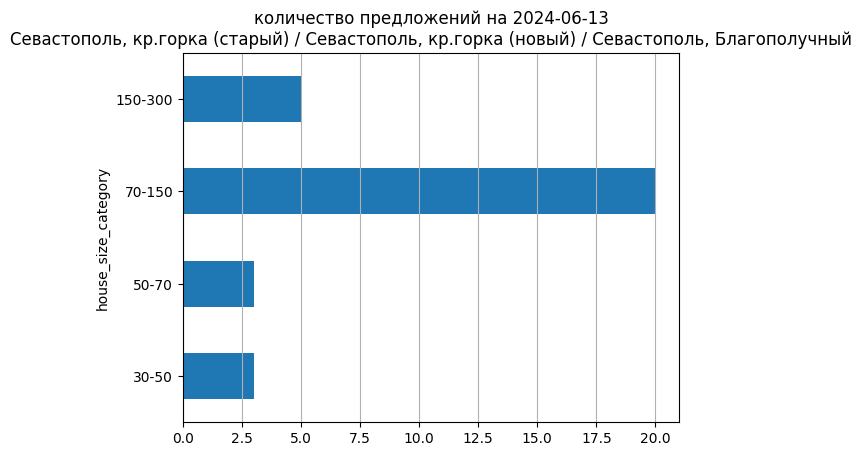

In [54]:
(
    gdf_last_local
    .groupby(['house_size_category'], observed=True)['url'].count()
    .plot.barh(title='количество предложений на '+ str( gdf['dt'].max()) + '\n' + ' / '.join(area_name) )
    .grid(axis='x')    
)

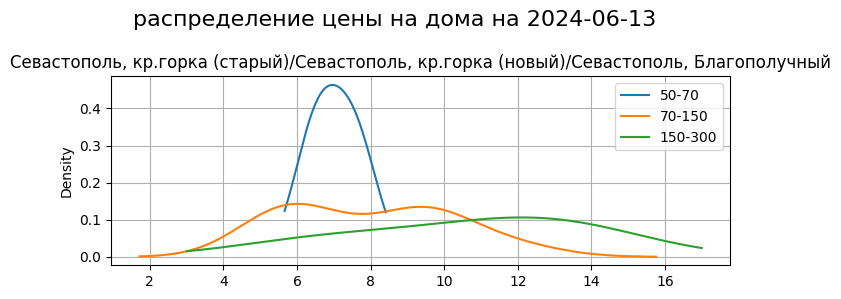

In [55]:
q_95 = gdf_last_local['priceM'].quantile(.95)

fig, ax = plt.subplots(figsize=(7,3) )
(
    gdf_last_local
    .query(f'(priceM<{q_95})&(house_size_category in {category})')
    .groupby(['house_size_category'],observed=True)
    ['priceM'].plot.kde(legend=True,ax=ax,title='/'.join(area_name), grid=True)   
)
fig.suptitle(f'распределение цены на дома на '+ str( gdf_last_local['dt'].max() ), fontsize=16)
fig.tight_layout()

----

In [56]:
# изменение цены по району
gdf_local = gdf.sjoin( frame_, how='inner', predicate='within') 

In [57]:
stat = (
        gdf_local
        .groupby(['house_size_category','month'],observed=True)
        ['priceM'].describe(percentiles=percentiles)
        #.dropna()
    )
display( stat )

count  mean  std   min    1%    5%   10%   25%  \
house_size_category month                                                     
30-50               2024-06  14.00  5.85 0.12  5.70  5.70  5.70  5.70  5.74   
50-70               2022-09   7.00  7.50 1.50  4.50  4.65  5.25  6.00  7.00   
                    2022-11  11.00  6.70 0.93  6.00  6.00  6.00  6.00  6.20   
                    2023-01   4.00  7.04 1.15  5.50  5.54  5.72  5.94  6.59   
                    2024-06  13.00  7.29 1.29  6.35  6.35  6.35  6.35  6.35   
70-150              2022-09  40.00  7.95 2.71  5.50  5.50  5.50  5.50  6.00   
                    2022-11 116.00  6.43 1.77  2.80  3.00  4.50  5.12  5.70   
                    2023-01  27.00  7.86 3.03  2.70  3.28  4.92  4.96  5.88   
                    2024-06 108.00  8.29 2.36  5.22  5.22  5.25  5.40  6.50   
150-300             2022-09  16.00 10.13 2.76  6.50  6.50  6.50  6.90  7.34   
                    2022-11  42.00 10.80 2.74  6.00  6.21  6.50  6.52  9.40   
                    2023-01   6.00 10.28 2.76  6.50  6.60  7.00  7.50  8.60   
                    2024-06  25.00 11.83 3.01  6.50  6.50  6.50  6.50 10.00   
300+                2022-11   4.00 14.80 0.00 14.80 14.80 14.80 14.80 14.80   

                              50%   75%   90%   95%   max  
house_size_category month                                  
30-50               2024-06  5.85  5.96  6.00  6.00  6.00  
50-70               2022-09  8.50  8.50  8.50  8.50  8.50  
                    2022-11  6.20  6.72  8.50  8.50  8.50  
                    2023-01  7.22  7.67  7.99  8.09  8.20  
                    2024-06  7.00  7.72  7.72  9.03 11.00  
70-150              2022-09  6.45  9.11 13.05 13.52 14.00  
                    2022-11  6.00  7.25  8.70  9.15 13.50  
                    2023-01  7.20  9.27 12.74 14.30 14.30  
                    2024-06  8.70  9.60 11.30 12.25 14.00  
150-300             2022-09 10.15 12.19 13.43 14.10 14.10  
                    2022-11 10.95 12.75 14.10 14.10 14.90  
                    2023-01 10.40 11.97 12.95 13.43 13.90  
                    2024-06 12.75 14.98 14.98 14.98 14.98  
300+                2022-11 14.80 14.80 14.80 14.80 14.80

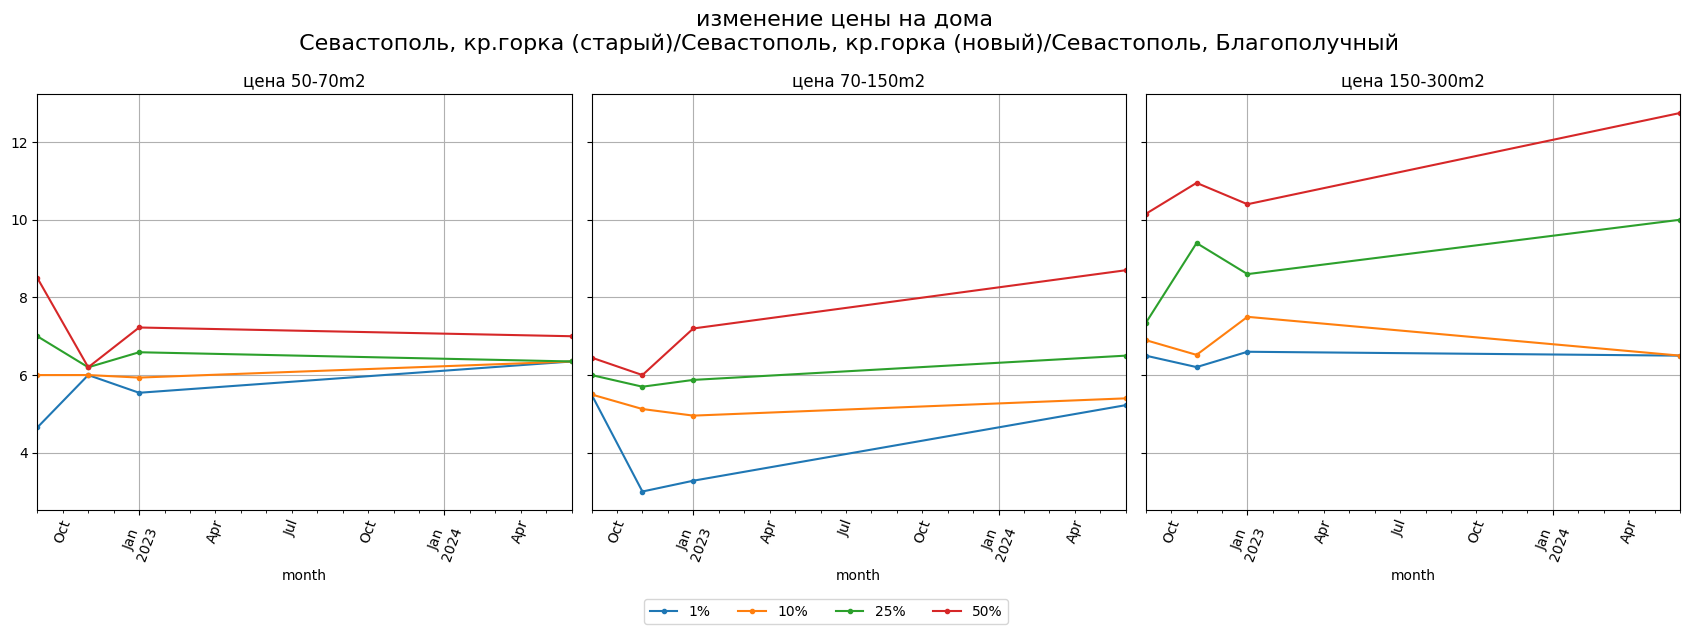

In [58]:
fig, ax = plt.subplots(1,len(sizes),figsize=(17,6), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(s),cols].plot(title=f'цена {s}m2', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'изменение цены на дома\n {'/'.join(area_name)}', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()